In [132]:
#価値反復法 ある行動を探るたびに次の状態価値と今の状態勝ちの差分を計算し，その差分だけ今の状態価値を増やす手法
#sarsa 収束が遅い　局所解に陥りにくい　Q学習は収束が早い
#パッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

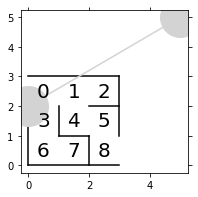

In [133]:
#マルコフ決定過程  
#パラメータθの初期値の準備
fig=plt.figure(figsize=(3,3))

plt.plot([0,3],[3,3],color='k')  
plt.plot([0,3],[0,0],color='k')  
plt.plot([0,0],[0,2],color='k')  
plt.plot([3,3],[1,3],color='k')  
plt.plot([1,1],[1,2],color='k')  
plt.plot([2,3],[2,2],color='k')  
plt.plot([2,1],[1,1],color='k')  
plt.plot([2,2],[0,1],color='k')  

#数字
for i in range(3):
  for j in range(3):
    plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center',va='center')

#円
circle,=plt.plot([0,5],[2,5],marker='o',color='#d3d3d3',markersize=40)

#目盛りと枠の非表示
plt.tick_params(axis='both', which='both',  bottom='off',  top='off',
                labelbottom='off', right='off', left='off', labelleft='off')
plt.box('off')

theta_0=np.array([
                  [np.nan,1,1,np.nan], #0 上　右　下 左
                  [np.nan,1,1,1], #1 
                  [np.nan,np.nan,np.nan,1], #2 
                  [1,np.nan,1,np.nan], #3 
                  [1,1,np.nan,np.nan], #4
                  [np.nan,np.nan,1,1], #5
                  [1,1,np.nan,np.nan], #6
                  [np.nan,np.nan,np.nan,1], #7               
]) 

In [134]:
#パラメータθを方策に変換  価値を計算する関数　行動価値関数Q　状態価値関数
def get_pi(theta): 
  #割合の計算
  [m,n]=theta.shape
  pi=np.zeros((m,n))
  for i in range(0,m):
    pi[i,:]=theta[i,:] / np.nansum(theta[i,:])
  pi=np.nan_to_num(pi)
  return pi

In [135]:
#パラメータθの初期値を方策に変換
pi_0=get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [136]:
#行動に従って次の状態を取得
def get_s_next(s,a):
  if a==0: #上
    return s-3
  elif a==1: #右
    return s+1 
  elif a==2: #下
    return s+3
  elif a==3: #左
    return s-1

In [137]:
#行動価値関数とはある状態である行動を探る価値を計算する関数
[a,b]=theta_0.shape
Q=np.random.rand(a,b)*theta_0
print(Q)

[[       nan 0.57884163 0.8506136         nan]
 [       nan 0.64765012 0.14420516 0.14213982]
 [       nan        nan        nan 0.81420695]
 [0.14420809        nan 0.50960677        nan]
 [0.28951632 0.86064883        nan        nan]
 [       nan        nan 0.04653798 0.90256021]
 [0.28964217 0.26986687        nan        nan]
 [       nan        nan        nan 0.75069983]]


In [138]:
#ランダムまたは行動価値関数に従って行動を取得
def get_a(s,Q,epsilon,pi_0):
  if np.random.rand()<epsilon:
    #ランダムに行動を選択
    return np.random.choice([0,1,2,3],p=pi_0[s])
  else:
    #行動価値関数で行動を選択
    return np.nanargmax(Q[s])  #期待値の高い行動を取得

In [139]:
#方策は現在の状態に応じて次の行動を決定する　sarsaの方策を更新するには行動価値関数を更新
#sarsaによる行動価値関数の更新
def sarsa(s,a,r,s_next,a_next,Q):  #sはエージェントがいるマス　aは左とか方角
  eta=0.1 #学習係数
  gamma=0.9 #時間割引率

  if s_next==8:
    Q[s,a]=Q[s,a]+eta*(r-Q[s,a])
  else:
    Q[s,a]=Q[s,a]+eta*(r+gamma*Q[s_next,a_next]-Q[s,a])
  return Q

In [140]:
#sarsaは次ステップの行動を使用する　ε-greedyのランダム性が含まれる 
#Q学習による行動価値関数の更新
def q_learning(s,a,r,s_next,a_next,Q):
  eta=0.1 #学習係数
  gamma=0.9 #時間割引率

  if s_next==8:
    Q[s,a]=Q[s,a]+eta*(r-Q[s,a])
  else:
    Q[s,a]=Q[s,a]+eta*(r+gamma*np.nanmax(Q[s_next,:])-Q[s,a])
  return Q

In [141]:
#1エピソードを実行して履歴と行動価値関数を取得
#1エピソードの実行
def play(Q,epsilon,pi):
  s=0 #状態
  a=a_next=get_a(s,Q,epsilon,pi) #行動の初期値
  s_a_history=[[0,np.nan]] #状態と行動の履歴

  #エピソード完了までのループ
  while True:
    #行動に従って次の状態の取得
    a=a_next
    s_next=get_s_next(s,a)

    #履歴の更新
    s_a_history[-1][1]=a
    s_a_history.append([s_next,np.nan])

    #終了判定
    if s_next==8:
      r=1
      a_next=np.nan
    else:
      r=0
      #行動価値関数に従って行動の取得
      a_next=get_a(s_next,Q,epsilon,pi)

    #行動価値関数の更新 Q学習ではq_learning
    Q=sarsa(s,a,r,s_next,a_next,Q)

    #終了判定
    if s_next==8:
      break
    else:
      s=s_next

  #履歴と行動価値関数を返す
  return [s_a_history,Q]

In [142]:
#エピソードを繰り返し実行して学習する
epsilon=0.5  #ε-greedy法のεの初期値

#エピソードを繰り返し実行して学習
for episode in range(10):
  #ε-greedyの値を少しずつ小さくする
  epsilon=epsilon/2

  #1エピソード実行して履歴と行動価値関数を取得
  [s_a_history,Q]=play(Q, epsilon, pi_0)

  #出力
  print('エピソード:{},　ステップ:{}'.format(episode,len(s_a_history)-1))

エピソード:0,　ステップ:240
エピソード:1,　ステップ:112
エピソード:2,　ステップ:54
エピソード:3,　ステップ:52
エピソード:4,　ステップ:44
エピソード:5,　ステップ:8
エピソード:6,　ステップ:8
エピソード:7,　ステップ:8
エピソード:8,　ステップ:10
エピソード:9,　ステップ:8


In [143]:
#アニメーションの定期処理を行う関数
def animate(i):
  state=s_a_history[i][0]
  circle.set_data((state%3)+0.5,2.5-int(state/3))
  return circle

#アニメーションの表示
anim=animation.FuncAnimation(fig,animate,\
        frames=len(s_a_history),interval=200,repeat=False)
HTML(anim.to_jshtml())